# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>
---

**Lab 05**: Data pipeline with Neo4j

**Date**: October 2nd 2025

**Student Name**:

**Professor**: Pablo Camarillo Ramirez

# Dataset description

Data comes from this data set: "https://www.kaggle.com/datasets/ahmedshahriarsakib/uber-eats-usa-restaurants-menus?select=restaurant-menus.csv"

# Data ingestion

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Examples on storage solutions with Neo4j") \
    .master("spark://spark-master:7077") \
    .config("spark.jars.packages", "org.neo4j:neo4j-connector-apache-spark_2.13:5.3.10_for_spark_3") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")
# Optimization (reduce the number of shuffle partitions)
spark.conf.set("spark.sql.shuffle.partitions", "5")

:: loading settings :: url = jar:file:/opt/spark/jars/ivy-2.5.3.jar!/org/apache/ivy/core/settings/ivysettings.xml
Ivy Default Cache set to: /root/.ivy2.5.2/cache
The jars for the packages stored in: /root/.ivy2.5.2/jars
org.neo4j#neo4j-connector-apache-spark_2.13 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-5746f6ef-1c86-4b63-b526-e9e68dec82a8;1.0
	confs: [default]
	found org.neo4j#neo4j-connector-apache-spark_2.13;5.3.10_for_spark_3 in central
	found org.neo4j#neo4j-connector-apache-spark_2.13_common;5.3.10_for_spark_3 in central
	found org.neo4j#caniuse-core;1.3.0 in central
	found org.neo4j#caniuse-api;1.3.0 in central
	found org.jetbrains.kotlin#kotlin-stdlib;2.1.20 in central
	found org.jetbrains#annotations;13.0 in central
	found org.neo4j#caniuse-neo4j-detection;1.3.0 in central
	found org.neo4j.driver#neo4j-java-driver-slim;4.4.21 in central
	found org.reactivestreams#reactive-streams;1.0.4 in central
	found io.netty#netty-handler;4.1.

In [ ]:
from axel_fernandez.spark_utils import SparkUtils

# Esquema para restaurants.csv
restaurants_schema_columns = [
    ("id", "int"),
    ("position", "int"),
    ("name", "string"),
    ("score", "float"),
    ("ratings", "int"),
    ("category", "string"),
    ("price_range", "string"),
    ("full_address", "string"),
    ("zip_code", "string"),  
    ("lat", "float"),
    ("lng", "float")
]


menus_schema_columns = [
    ("restaurant_id", "int"),
    ("item_name", "string"),
    ("category", "string"),
    ("description", "string"),
    ("price", "float")
]

restaurants_schema = SparkUtils.generate_schema(restaurants_schema_columns)
menus_schema = SparkUtils.generate_schema(menus_schema_columns)

base_path = "/opt/spark/work-dir/data/Restaurant/"

restaurants_df = spark.read \
    .option("header", "true") \
    .schema(restaurants_schema) \
    .csv(base_path + "restaurants.csv")

menus_df = spark.read \
    .option("header", "true") \
    .schema(menus_schema) \
    .csv(base_path + "restaurant-menus.csv")

print("Restaurantes:")
restaurants_df.show(10, truncate=False)

print("Menús:")
menus_df.show(10, truncate=False)

Restaurantes:


+---+--------+----------------------------------------------+-----+-------+---------------------------------------------------------+-----------+-------------------------------------------------+--------+---------+---------+
|id |position|name                                          |score|ratings|category                                                 |price_range|full_address                                     |zip_code|lat      |lng      |
+---+--------+----------------------------------------------+-----+-------+---------------------------------------------------------+-----------+-------------------------------------------------+--------+---------+---------+
|1  |19      |PJ Fresh (224 Daniel Payne Drive)             |NULL |NULL   |Burgers, American, Sandwiches                            |$          |224 Daniel Payne Drive, Birmingham, AL, 35207    |35207   |33.562366|-86.8307 |
|2  |9       |J' ti`'z Smoothie-N-Coffee Bar                |NULL |NULL   |Coffee and Tea, Breakfast

# Transformations

In [ ]:
from pyspark.sql.functions import col, when, coalesce, lit, trim

restaurants_df_clean = restaurants_df.dropDuplicates(["id"]) \
    .withColumn("name", trim(col("name"))) \
    .withColumn("price_range", 
                when(col("price_range") == "$", "Inexpensive")
                .when(col("price_range") == "$$", "Moderately expensive")
                .when(col("price_range") == "$$$", "Expensive")
                .when(col("price_range") == "$$$$", "Very Expensive")
                .otherwise("N/A")) \
    .withColumn("score", coalesce(col("score"), lit(0.0))) \
    .withColumn("ratings", coalesce(col("ratings"), lit(0))) \
    .withColumn("category", coalesce(col("category"), lit("N/A"))) \
    .withColumn("full_address", coalesce(col("full_address"), lit("N/A"))) \
    .withColumn("zip_code", coalesce(col("zip_code"), lit("N/A")))



restaurants_df_clean.show(20, truncate=False)

+---+--------+---------------------------------------------------+-----------------+-------+------------------------------------------------------------------------+--------------------+----------------------------------------------------+----------+---------+----------+
|id |position|name                                               |score            |ratings|category                                                                |price_range         |full_address                                        |zip_code  |lat      |lng       |
+---+--------+---------------------------------------------------+-----------------+-------+------------------------------------------------------------------------+--------------------+----------------------------------------------------+----------+---------+----------+
|3  |6       |Philly Fresh Cheesesteaks (541-B Graymont Ave)     |0.0              |0      |American, Cheesesteak, Sandwiches, Alcohol                              |Inexpensive        

In [ ]:
from pyspark.sql.functions import col

menus_df_clean = menus_df \
    .dropDuplicates(["restaurant_id", "item_name", "category", "description", "price"]) \
    .withColumn("item_name", trim(col("item_name"))) \
    .withColumn("category", coalesce(col("category"), lit("Uncategorized"))) \
    .withColumn("price", coalesce(col("price"), lit(0.0)))  

valid_restaurant_ids = restaurants_df_clean.select("id").distinct()
menus_df_valid = menus_df_clean \
    .join(valid_restaurant_ids, menus_df_clean["restaurant_id"] == valid_restaurant_ids["id"], "inner") \
    .select(menus_df_clean["*"]) \
    .cache()

menus_df_valid.show(20, truncate=False)

In [5]:
from pyspark.sql.functions import concat, lit


# Preparación de nodos de restaurantes para Neo4j
restaurant_nodes = restaurants_df_clean.select(
    col("id"),
    col("name"),
    col("category"),
    col("price_range"),
    col("score"),
    col("full_address"),
    col("zip_code"),
    col("lat"),
    col("lng")
)

# Preparación de nodos de menú para Neo4j
menu_nodes = menus_df_valid.select(
    # Crear ID único para cada elemento de menú
    concat(col("restaurant_id"), lit("_"), col("item_name")).alias("id"),
    col("item_name").alias("name"),
    col("category"),
    col("description"),
    col("price"),
    col("restaurant_id")  # Mantener el restaurant_id para la relación
).dropDuplicates(["id"])

print(f"Registros en restaurant_nodes: {restaurant_nodes.count()}")
print(f"Registros en menu_nodes: {menu_nodes.count()}")

Registros en restaurant_nodes: 63470


Registros en menu_nodes: 610597


# Writing Data in Neo4j

En mi caso profe logre tener muchos problemas con la escritura ya que a lo que estuve investigando al momento de escribir nodos al crear la realacion debes de buscar el nodo origen con el destino por lo que depende del numero de nodos cuanto llega a tardar esta relacion.

En mi caso hay 65 mil resturantes masomenos y 650,000 items de menu para dichos restaurantes por lo que si tardaba bastante. 

Investigue y vi que podia moverle la memoria al contenedor de ne4j para que soporte mas ya que otro problema era que si queria procesar los 660mil nodos de golpe abortaba porque se excedia o no podia procesar tanto de golpe por lo que ayudandome de IA me recomendo subir por batch. Aun asi las relaciones seguian tardandome demasiado por lo que opte en limitar a 20 mil nodos. de estos 20 mil nodos de restaurates no todos tienen relaciones ya que al no estar todos los nodos del menu y al ser mas de 600 mil puede que no haya llegado el item correspondiente para algun restaurante. 

In [ ]:
# Configuración de Neo4j
neo4j_url = "bolt://neo4j-iteso:7687"
neo4j_user = "neo4j"
neo4j_passwd = "neo4j@1234"

limited_restaurants = restaurant_nodes.limit(20000)
total_restaurants = limited_restaurants.count()

# Definir el tamaño del lote para escritura
batch_size = 200

# Escribir los restaurantes limitados
limited_restaurants.repartition((total_restaurants // batch_size) + 1) \
    .write \
    .format("org.neo4j.spark.DataSource") \
    .mode("Append") \
    .option("url", neo4j_url) \
    .option("authentication.basic.username", neo4j_user) \
    .option("authentication.basic.password", neo4j_passwd) \
    .option("labels", ":Restaurant") \
    .option("node.keys", "id") \
    .option("batch.size", batch_size) \
    .save()


Base de datos Neo4j limpiada correctamente.
Total de restaurantes a escribir: 20000 (limitado a 10,000)


Escritura de 20000 restaurantes completada


In [ ]:
limited_menus = menu_nodes.limit(20000)
total_menus = limited_menus.count()

# Escribir los elementos de menú limitados
limited_menus.repartition((total_menus // batch_size) + 1) \
    .write \
    .format("org.neo4j.spark.DataSource") \
    .mode("Append") \
    .option("url", neo4j_url) \
    .option("authentication.basic.username", neo4j_user) \
    .option("authentication.basic.password", neo4j_passwd) \
    .option("labels", ":MenuItem") \
    .option("node.keys", "id") \
    .option("batch.size", batch_size) \
    .save()


Total de elementos de menú a escribir: 20000 (limitado a 10,000)


Escritura de 20000 elementos de menú completada


In [ ]:
relationship_df = limited_menus.select(
    col("restaurant_id").alias("src"),  # ID del restaurante (origen)
    col("id").alias("dst")              # ID del elemento de menú (destino)
)

relationship_df.repartition((relationship_df.count() // batch_size) + 1) \
    .write \
    .format("org.neo4j.spark.DataSource") \
    .mode("Append") \
    .option("url", neo4j_url) \
    .option("authentication.basic.username", neo4j_user) \
    .option("authentication.basic.password", neo4j_passwd) \
    .option("relationship", "HAS_MENU_ITEM") \
    .option("relationship.save.strategy", "keys") \
    .option("relationship.source.labels", ":Restaurant") \
    .option("relationship.source.save.mode", "match") \
    .option("relationship.source.node.keys", "src:id") \
    .option("relationship.target.labels", ":MenuItem") \
    .option("relationship.target.save.mode", "match") \
    .option("relationship.target.node.keys", "dst:id") \
    .option("batch.size", batch_size) \
    .save()


Total de relaciones a escribir: 20000


Escritura de 20000 relaciones completada


# Read and Query Graphs with PySpark

In [ ]:
# Top restaurantes con mejor puntuación
top_restaurants = spark.read \
    .format("org.neo4j.spark.DataSource") \
    .option("url", neo4j_url) \
    .option("authentication.basic.username", neo4j_user) \
    .option("authentication.basic.password", neo4j_passwd) \
    .option("query",
            """
                MATCH (r:Restaurant)
                WHERE r.score > 0
                RETURN r.id as id, r.name as name, r.category as category, 
                       r.price_range as price_range, r.score as score
                ORDER BY r.score DESC
            """) \
    .load()

print("Restaurantes con mejor puntuación:")
top_restaurants.show(truncate=False)

Top 10 restaurantes con mejor puntuación:
+-----+-------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------+--------------------+-----+
|id   |name                                             |category                                                                                                                                        |price_range         |score|
+-----+-------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------+--------------------+-----+
|26569|Green Bamboo Asian Bistro                        |Chinese, Asian Fusion, Family Friendly                                                                                                          |Moderately expensive|5.0  |
|43691|Tropical Smoothie Cafe - Texas 

In [ ]:
# Obtener todos los elementos de menú de un restaurante específico mediante su ID
restaurant_menu = spark.read \
    .format("org.neo4j.spark.DataSource") \
    .option("url", neo4j_url) \
    .option("authentication.basic.username", neo4j_user) \
    .option("authentication.basic.password", neo4j_passwd) \
    .option("query",
            """
                MATCH (r:Restaurant)-[:HAS_MENU_ITEM]->(m:MenuItem)
                WHERE r.id = 14026 
                RETURN r.name as restaurant_name, 
                       m.name as item_name, 
                       m.category as category,
                       m.price as price
                ORDER BY m.category, m.price DESC
            """) \
    .load()

print("Menú completo del restaurante:")
restaurant_menu.show(truncate=False)

Menú completo del restaurante:
+------------------------------------+----------------------+---------------------------------+-----+
|restaurant_name                     |item_name             |category                         |price|
+------------------------------------+----------------------+---------------------------------+-----+
|Maephim Thai Restaurant (Marysville)|Mae​ ​Phim​ ​Signature|Avocado​ ​Prawns​ ​Curry​ ​Dinner|0.0  |
|Maephim Thai Restaurant (Marysville)|Thai Stir-Fries       |Ginger Dinner                    |0.0  |
|Maephim Thai Restaurant (Marysville)|Noodles               |Rama​ ​Noodle​ ​Dinner           |0.0  |
|Maephim Thai Restaurant (Marysville)|Side Orders           |Steamed​ ​Mixed​ ​Vegetables     |0.0  |
|Maephim Thai Restaurant (Marysville)|Soups and Salads      |Tom​ ​Yum​ ​Pug​ ​Soup​ ​Dinner  |0.0  |
+------------------------------------+----------------------+---------------------------------+-----+



In [ ]:
# Restaurantes con más elementos de menú. 
restaurants_with_most_items = spark.read \
    .format("org.neo4j.spark.DataSource") \
    .option("url", neo4j_url) \
    .option("authentication.basic.username", neo4j_user) \
    .option("authentication.basic.password", neo4j_passwd) \
    .option("query",
            """
                MATCH (r:Restaurant)-[:HAS_MENU_ITEM]->(m:MenuItem)
                WITH r.name as restaurant_name, r.category as category, count(m) as menu_size
                RETURN restaurant_name, category, menu_size
                ORDER BY menu_size DESC
            """) \
    .load()

restaurants_with_most_items.show(truncate=False)




+--------------------------------------------------------------------------+---------------------------------------------------------------------------------+---------+
|restaurant_name                                                           |category                                                                         |menu_size|
+--------------------------------------------------------------------------+---------------------------------------------------------------------------------+---------+
|Rite Aid (7041 PACIFIC AVENUE)                                            |Everyday Essentials, Convenience, Home &amp; Personal Care, Snacks               |10       |
|BJ's Restaurant &amp; Brewhouse (Southcenter #479)                        |American, Burgers, Pizza, Family Meals, Group Friendly, Alcohol                  |8        |
|Rite Aid (305 COOPER POINT ROAD NW)                                       |Everyday Essentials, Convenience, Home &amp; Personal Care, Snacks             

## De la tabla de arriba filtramos el menu size y vemos dentro de local la relacion

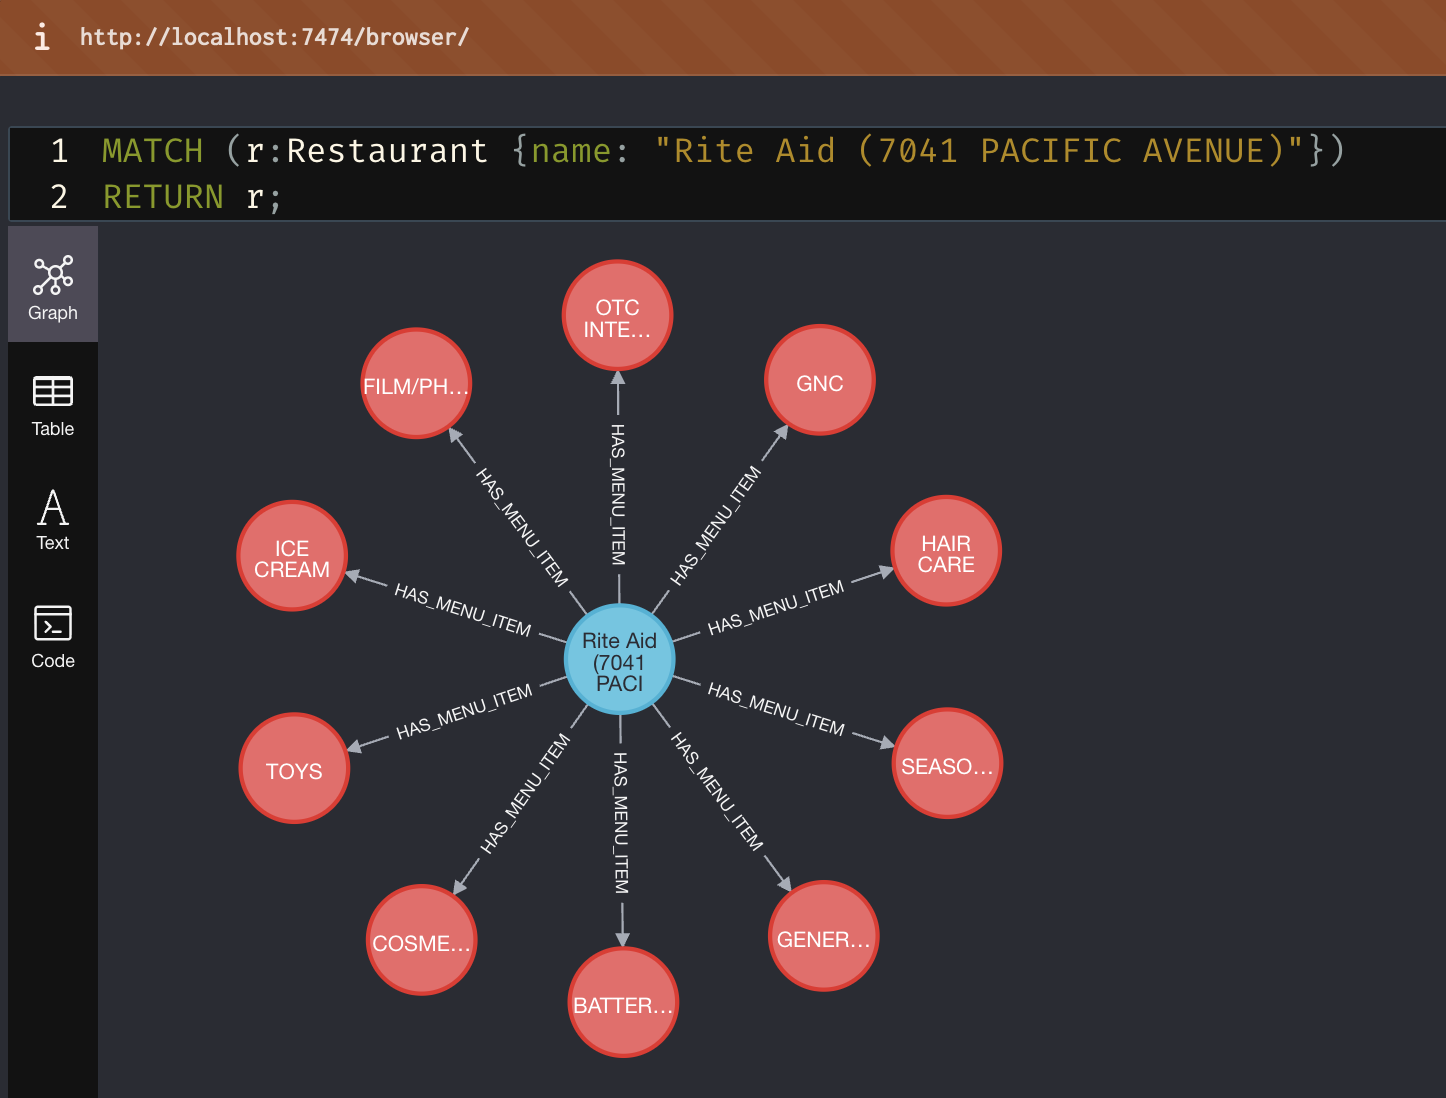